In [1]:
import sys
sys.path.append('/content/drive/MyDrive/colab')
PACKAGE_PATH = '/content/drive/MyDrive/colab/packages'
if PACKAGE_PATH not in sys.path:
    sys.path.append(PACKAGE_PATH)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [20]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint
import numpy as np

In [4]:
df=pd.read_csv('/content/drive/MyDrive/colab/data/desi_sample_clean.csv',index_col=0)

In [5]:
for col in df.columns:
  print(col+":",df[col].dtype)

z: float64
zerr: float64
chi2: float64
spectype: object
morphtype: object
ebv: float64
flux_g: float64
flux_r: float64
flux_z: float64
flux_w1: float64
flux_w2: float64
flux_ivar_g: float64
flux_ivar_r: float64
flux_ivar_z: float64
flux_ivar_w1: float64
flux_ivar_w2: float64
fiberflux_g: float64
fiberflux_r: float64
fiberflux_z: float64
fibertotflux_g: float64
fibertotflux_r: float64
fibertotflux_z: float64
gaia_phot_g_mean_mag: float64
gaia_phot_bp_mean_mag: float64
gaia_phot_rp_mean_mag: float64


In [6]:
df["morphtype"] = df["morphtype"].fillna("unknown")
object_cols = df.select_dtypes(include="object").columns
df[object_cols] = df[object_cols].astype("category")

In [7]:
scaler=StandardScaler()

In [8]:
df_exp = df.copy()
num_cols = df_exp.select_dtypes(include=["float64", "int64"]).columns
df_exp[num_cols] = scaler.fit_transform(df_exp[num_cols])

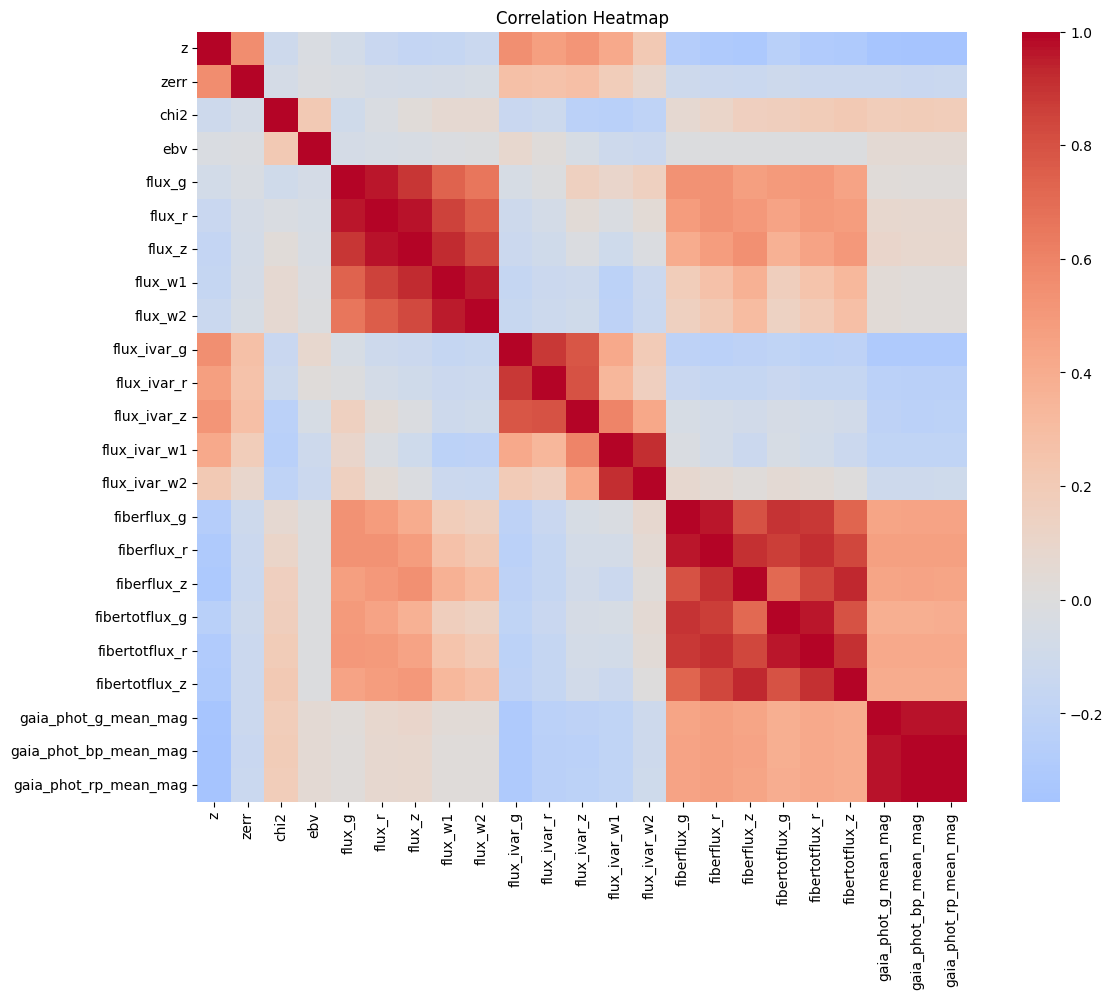

In [9]:
plt.figure(figsize=(14, 10))
sns.heatmap(df_exp[num_cols].corr(), cmap="coolwarm", center=0, square=True)
plt.title("Correlation Heatmap")
plt.show()

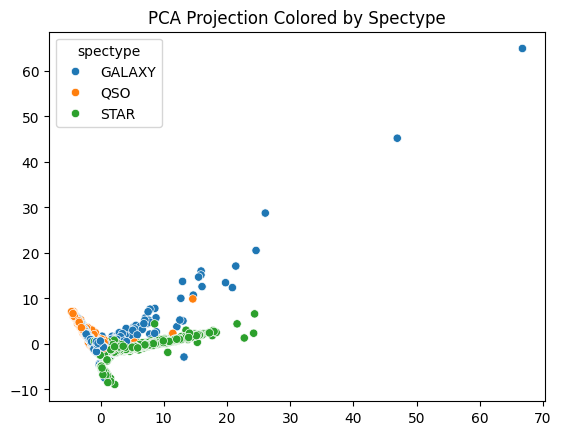

In [10]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_exp[num_cols])
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df["spectype"])
plt.title("PCA Projection Colored by Spectype")
plt.show()

In [11]:
components=pd.DataFrame(pca.components_, columns=num_cols, index=["PC1", "PC2"])
print(components)
print("Explained variance ratio:", pca.explained_variance_ratio_)

            z      zerr      chi2       ebv    flux_g    flux_r    flux_z  \
PC1 -0.164985 -0.083022  0.070716 -0.000317  0.228765  0.246256  0.244296   
PC2  0.237065  0.147600 -0.131749 -0.055866  0.313216  0.282278  0.259782   

      flux_w1   flux_w2  flux_ivar_g  ...  flux_ivar_w2  fiberflux_g  \
PC1  0.194601  0.175187    -0.147939  ...     -0.033316     0.293428   
PC2  0.220972  0.204883     0.281468  ...      0.215876     0.033804   

     fiberflux_r  fiberflux_z  fibertotflux_g  fibertotflux_r  fibertotflux_z  \
PC1     0.313312     0.305932        0.285049        0.306862        0.299138   
PC2     0.036895     0.037123        0.031105        0.033988        0.034467   

     gaia_phot_g_mean_mag  gaia_phot_bp_mean_mag  gaia_phot_rp_mean_mag  
PC1              0.200938               0.201387               0.200893  
PC2             -0.239890              -0.247547              -0.245326  

[2 rows x 23 columns]
Explained variance ratio: [0.35080769 0.17773533]


Cross-validation scores (F1 macro):
Fold 1: 0.9816
Fold 2: 0.9646
Fold 3: 0.9728
Fold 4: 0.9748
Fold 5: 0.9797
Mean F1 macro: 0.9747


<ipython-input-12-3ab01f8eb54d>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


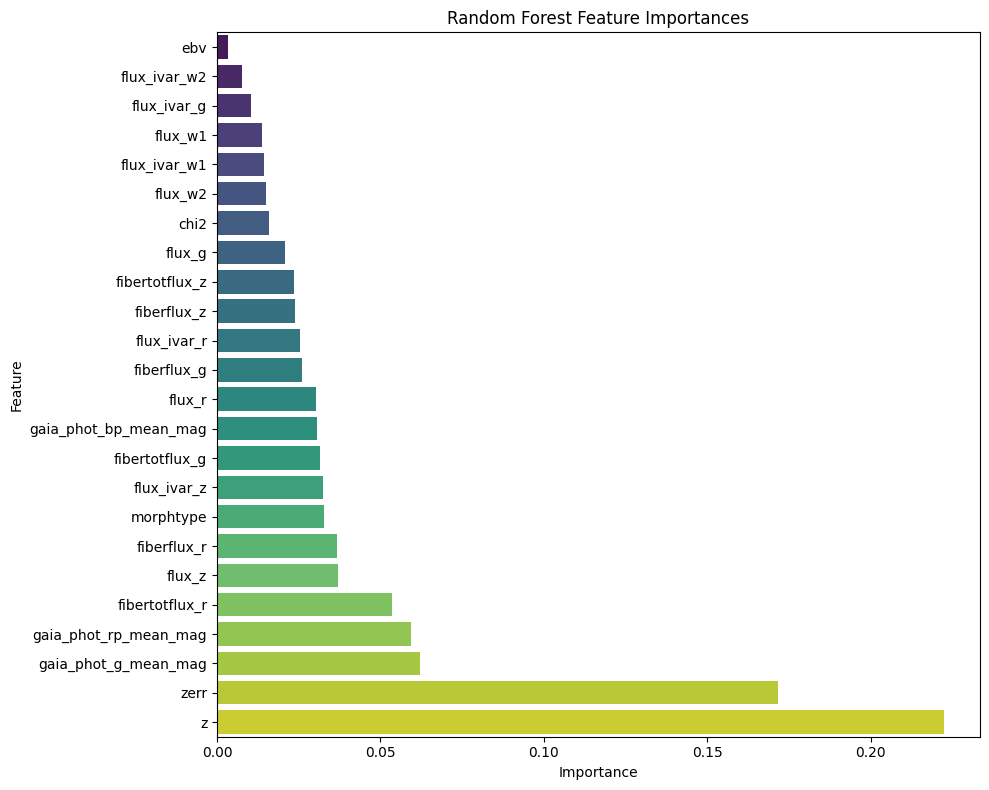

In [12]:
df_model = df.copy()

X = df_model.drop(columns=["spectype"])
y = df_model["spectype"]

for col in X.select_dtypes(include="category").columns:
    X[col] = X[col].cat.codes


rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    random_state=42,
    class_weight="balanced",
    n_jobs=-1
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Cross-validation scores (F1 macro):")
scores = cross_val_score(rf, X, y, cv=cv, scoring="f1_macro")
for i, s in enumerate(scores, 1):
    print(f"Fold {i}: {s:.4f}")
print(f"Mean F1 macro: {scores.mean():.4f}")

rf.fit(X, y)
importances = rf.feature_importances_
feature_names = X.columns
sorted_idx = np.argsort(importances)


plt.figure(figsize=(10, 8))
sns.barplot(
    x=importances[sorted_idx],
    y=feature_names[sorted_idx],
    palette="viridis"
)
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [21]:
param_distributions = {
    'n_estimators': randint(20, 200),
    'max_depth': [None, 5,10, 15,],
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5),
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestClassifier(random_state=42, class_weight="balanced", n_jobs=-1)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=30,
    scoring='f1_macro',
    cv=cv,
    random_state=42,
    verbose=2,
    n_jobs=-1
)

random_search.fit(X, y)

print("Best parameters found:", random_search.best_params_)
print("Best F1 macro score:", random_search.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 6, 'n_estimators': 92}
Best F1 macro score: 0.9775172825817187
